# Covid-19 Radiology Segmentation & Classification
COMP 478 Project
<br>
Jeremy Gaudet
<br>
ID: 40045224
<br>
April 25, 2021

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator,array_to_img
import pandas as pd
import numpy as np
from PIL import Image
from datetime import datetime
import io

import os
from glob import glob

In [2]:
# import sys
# from google.colab import drive
# drive.mount('/content/gdrive')
# sys.path.append('/content/gdrive/My Drive/COMP478 Project/')
# %cd /content/gdrive/My Drive/COMP478 Project/

### Global variables

In [3]:
PATH = '/Users/jeremygaudet/Downloads/COVID-19_Radiography_Dataset'
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
IMAGE_WIDTH = IMAGE_SIZE[0]
IMAGE_HEIGHT = IMAGE_SIZE[1]

### Load the images

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="grayscale"
)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="grayscale"
)

Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [6]:
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=20,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    horizontal_flip=True,
#                                    validation_split=0.2)

# val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train_ds = train_datagen.flow_from_directory(directory=PATH, 
#                                              target_size=IMAGE_SIZE,
#                                              subset='training',
#                                              shuffle=True,
#                                              batch_size=BATCH_SIZE)

# val_ds = val_datagen.flow_from_directory(directory=PATH, 
#                                          target_size=IMAGE_SIZE,
#                                          subset='validation',
#                                          shuffle=False,
#                                          batch_size=BATCH_SIZE)

# Data Analysis

In this dataset, the chest x-ray images are divided into four classes:

In [7]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print(CLASS_NAMES)

['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']


The number of images in each class, however, is not evenly distrubuted, as can be seen in the following tables and graph. The biggest difference is between 'Viral Pneumonia' and 'Normal', where the latter has almost eight times as many instances as the former.

In [8]:
# Get all training and validation labels and put them into separate lists
# NOTE This can take a while
training_labels = np.concatenate([y for x, y in train_ds], axis=0)
validation_labels = np.concatenate([y for x, y in val_ds], axis=0)

In [9]:
# Use pandas to store the count of each class in the training set
unique, counts = np.unique(training_labels, return_counts=True)
train_df = pd.DataFrame(dict(zip(CLASS_NAMES, counts)).items(), columns=["class", "image count"])
# Do the same for validation set
unique, counts = np.unique(validation_labels, return_counts=True)
val_df = pd.DataFrame(dict(zip(CLASS_NAMES, counts)).items(), columns=["class", "image count"])

print('Distribution of training data:\n')
print(train_df)
print('\n\nDistribution of validation data:\n')
print(val_df)

Distribution of training data:

             class  image count
0            COVID         2907
1     Lung Opacity         4825
2           Normal         8137
3  Viral Pneumonia         1063


Distribution of validation data:

             class  image count
0            COVID          709
1     Lung Opacity         1187
2           Normal         2055
3  Viral Pneumonia          282


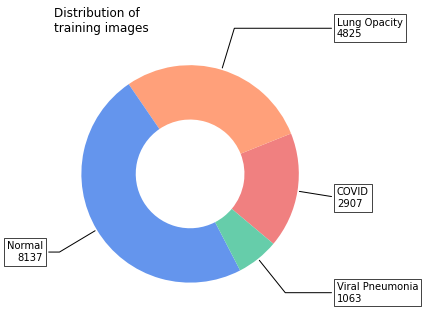

In [10]:
def display_distribution_donut(data_frame):
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

    categories = data_frame['class']
    img_count = data_frame['image count']

    wedges, texts = ax.pie(
        img_count, 
        wedgeprops=dict(width=0.5), 
        startangle=-40, 
        colors=['lightcoral','lightsalmon', 'cornflowerblue', 'mediumaquamarine'])

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(f'{categories[i]}\n{img_count[i]}', xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    plt.title("Distribution of\ntraining images", loc='left')
    plt.show()

display_distribution_donut(train_df)

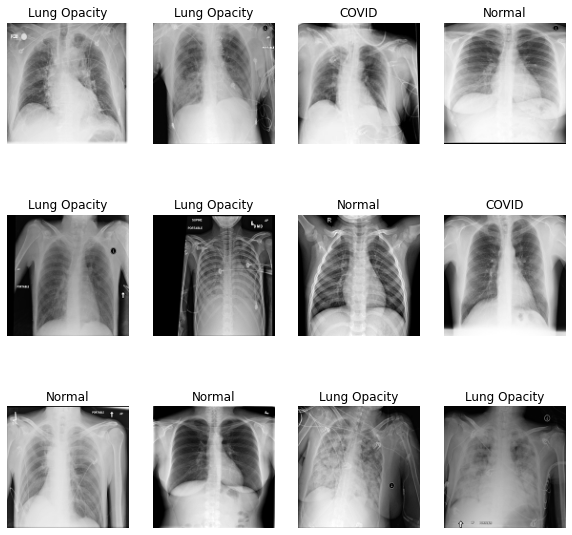

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 128, 128, 1)
(32,)


# Image Processing

In [13]:
from keras import layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMAGE_HEIGHT, 
                                                              IMAGE_WIDTH,
                                                              1)),
    # layers.experimental.preprocessing.RandomRotation(0.01),
    # layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

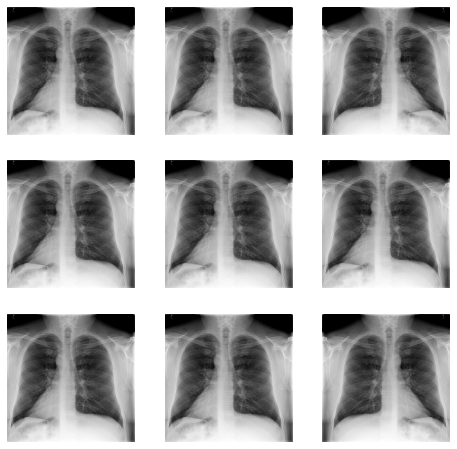

In [14]:
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")

# Classification

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
model = tf.keras.Sequential([ 
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(NUM_CLASSES)
])

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 1)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)      

In [18]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
530/530 [==============================] - 71s 133ms/step - loss: 0.9207 - accuracy: 0.6101 - val_loss: 0.5542 - val_accuracy: 0.7817
Epoch 2/10
530/530 [==============================] - 67s 126ms/step - loss: 0.5374 - accuracy: 0.7931 - val_loss: 0.4354 - val_accuracy: 0.8384
Epoch 3/10
530/530 [==============================] - 66s 124ms/step - loss: 0.4188 - accuracy: 0.8416 - val_loss: 0.3964 - val_accuracy: 0.8514
Epoch 4/10
530/530 [==============================] - 66s 125ms/step - loss: 0.3611 - accuracy: 0.8639 - val_loss: 0.3509 - val_accuracy: 0.8670
Epoch 5/10
530/530 [==============================] - 66s 125ms/step - loss: 0.3097 - accuracy: 0.8846 - val_loss: 0.3431 - val_accuracy: 0.8750
Epoch 6/10
530/530 [==============================] - 66s 125ms/step - loss: 0.2836 - accuracy: 0.8959 - val_loss: 0.3784 - val_accuracy: 0.8568
Epoch 7/10
530/530 [==============================] - 66s 125ms/step - loss: 0.2597 - accuracy: 0.9066 - val_loss: 0.3854 - val_ac

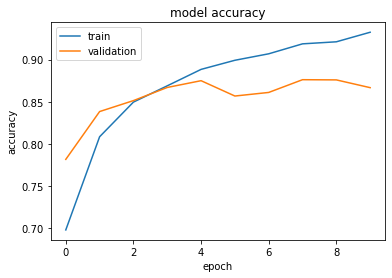

In [19]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

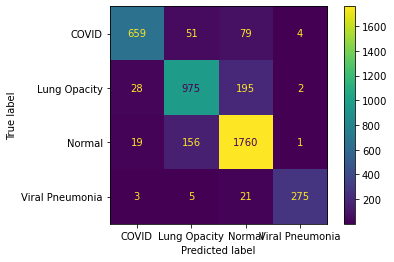


                  precision    recall  f1-score   support

          COVID       0.83      0.93      0.88       709
   Lung Opacity       0.81      0.82      0.82      1187
         Normal       0.91      0.86      0.88      2055
Viral Pneumonia       0.90      0.98      0.94       282

       accuracy                           0.87      4233
      macro avg       0.86      0.90      0.88      4233
   weighted avg       0.87      0.87      0.87      4233



In [20]:
def validation_data_categories(test_images):
    y_pred = model.predict(test_images)
    predicted_cat = tf.argmax(y_pred, axis=1)
    true_cat = tf.concat([y for x, y in test_images], axis=0)
    return true_cat, predicted_cat

def plot_confusion_matrix(true_cat, predicted_cat):
    cm = confusion_matrix(predicted_cat, true_cat)
    display = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES).plot()
    plt.show()

# Show the confusion matrix and the report
true_cat, pred_cat = validation_data_categories(val_ds)
plot_confusion_matrix(true_cat, pred_cat)
print('\n', classification_report(true_cat, pred_cat, target_names=CLASS_NAMES))

This image is Normal with 57.84% confidence


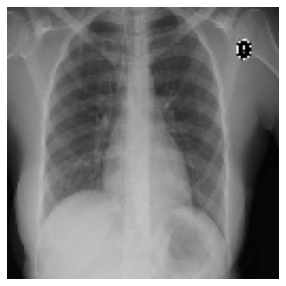

In [24]:
# test_image_path = "/Users/jeremygaudet/Downloads/istockphoto-173883249-612x612.jpg"
# test_image_path = "/Users/jeremygaudet/Downloads/c3-1-e1586266398823.jpg.webp"
test_image_path = "/Users/jeremygaudet/Downloads/normal-lung-xray-15x10-by-Yale-Rosen.jpg"

img = keras.preprocessing.image.load_img(test_image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), color_mode='grayscale')

# Plot image
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.axis("off")

# Load a model
# model_256 = keras.models.load_model('models/covid_lung_model_256_preprocess_drop.h5')

# Preprocess image
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
# Make predictions on images
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
# Get index for highest confidence class
idx = np.argmax(score)

print(f'This image is {CLASS_NAMES[idx]} with {score[idx]*100:0.2f}% confidence')

In [61]:
# Save the entire model to a HDF5 file.
# !mkdir models/
# model.save('models/covid_lung_model_256_preprocess_drop_big.h5')